In [2]:
import os 
import re
import matplotlib.pyplot as plt
import rmgpy.chemkin
import numpy as np
import cantera as ct
import pandas as pd
%matplotlib inline



In [3]:
def load_chemkin_file(path): 
    """ 
    Load Chemkin file and extract the reactions and species.
    Path should be the path to the species folder.
    """
    
    full_path = os.path.join(path,'chemkin')
    chemkin_path = os.path.join(full_path,'copies', 'copy_chem_annotated.inp')
   # chemkin_path = os.path.join(full_path,'chem_annotated.inp')
    dictionary_path = os.path.join(full_path,'species_dictionary.txt')
    transport_path = os.path.join(full_path,'tran.dat')

    species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin_path, dictionary_path=dictionary_path, transport_path=transport_path)

    return species_list, reaction_list

In [ ]:
############# load the chemkin file and the cantera dataframe ################

#file = 'sensitivites_copy_chem_annotated.cti.csv'
#species_list, reaction_list = load_chemkin_file('/work/westgroup/nora/Code/projects/halogens/refrigerants/singles/Burgess_Comments/methane_with_added_2_BTP/cantera/Nora/2_BTP')


## Subtracted Sensitivities

In [6]:
#we want to focus on the top ___ most sensitive reactions 
n = 20 #len(reaction_list)

In [7]:
def plot_sensitivity(csv_file):
    ############ plotting stuff

    df = pd.read_csv(f'./{csv_file}')

    match = re.search('(\.[0-9][0-9][0-9])[0-9]+_sensitivities.csv', file)
    btp_moles = float(match.group(1))

    #volume fraction of BTP = x/(x+1+3.76+0.5). when BTP vol frac is 3%, moles of BTP (normalized to O2) is 0.16268
    vf = btp_moles/(btp_moles+1+3.76+0.5)*100
    
    fig, ax = plt.subplots()

    plt.xlabel('Sensitivity')
    plt.title(f"Sensitivity for NIST model at 2_BTP volume fraction {vf:.2f}%")

    ############# iterate over rows of csv file. 

    for index,row in df.head(n).iterrows(): #Only iterate over the first n rows


        sensitivity, ct_equation, = row['sensitivity'], row['cantera equation']
        ax.barh(ct_equation, sensitivity, color='b', align='center')


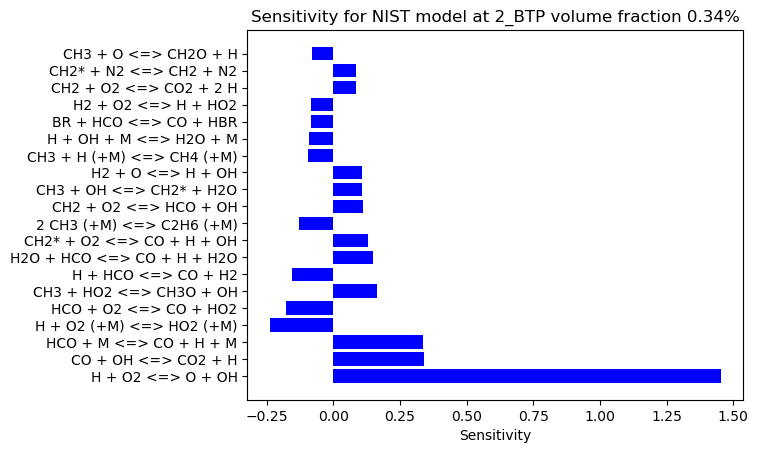

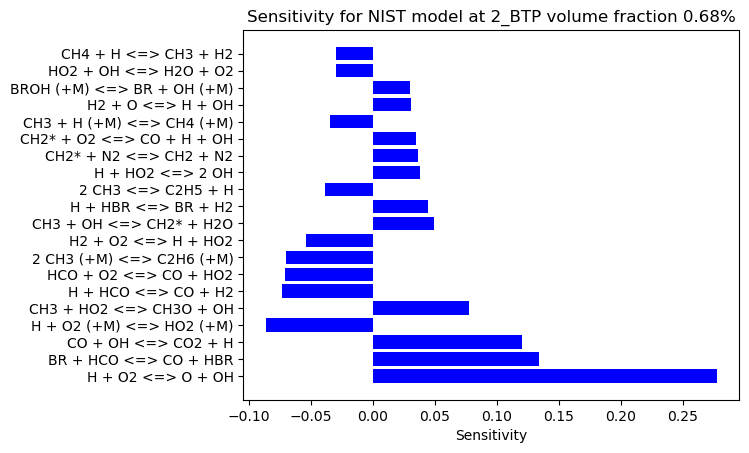

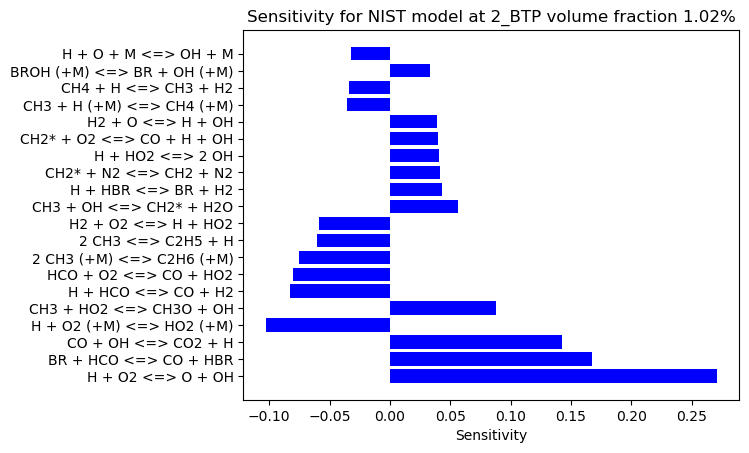

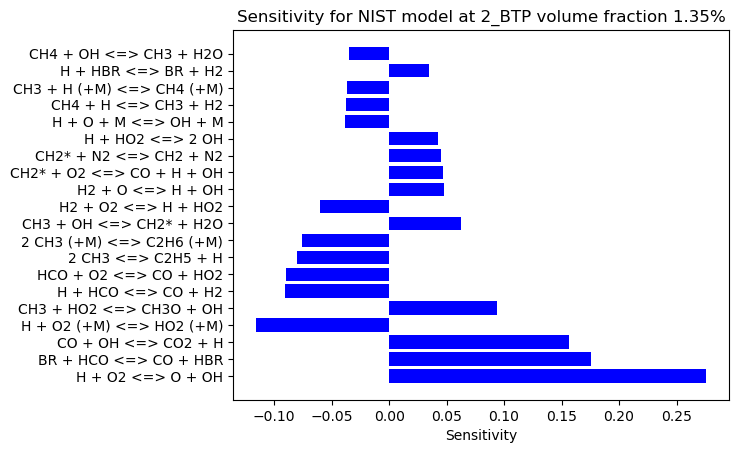

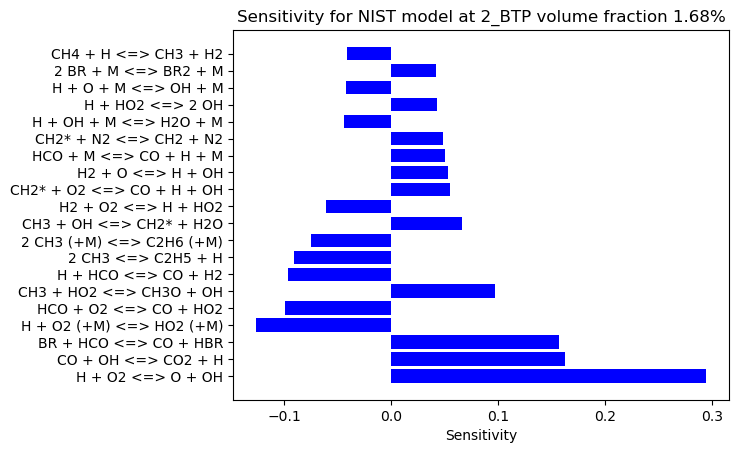

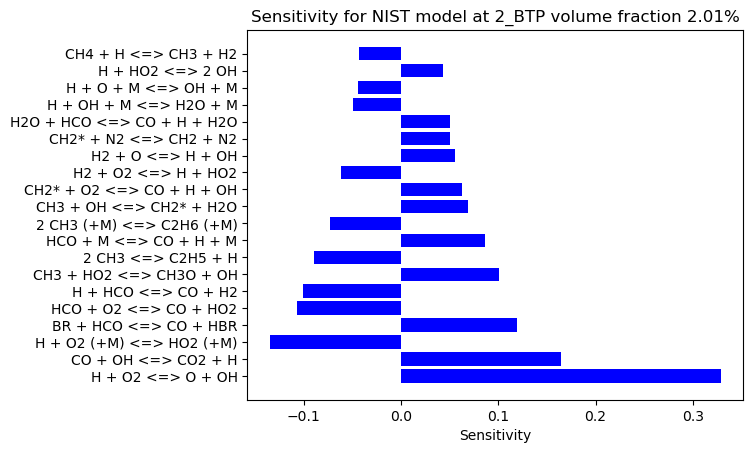

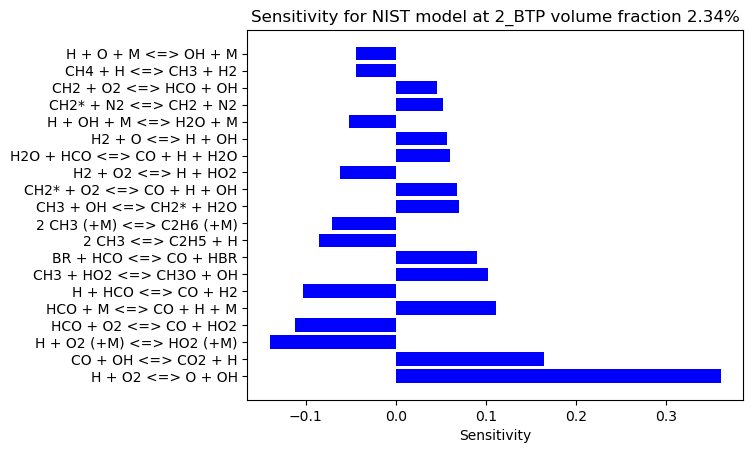

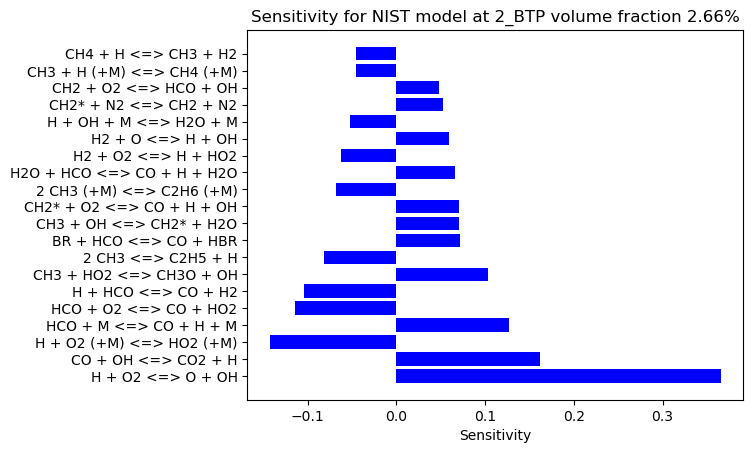

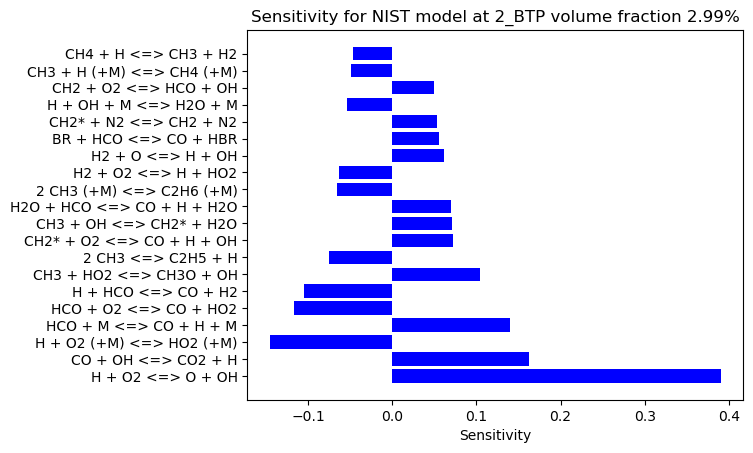

In [8]:
list_of_csvs = [file for file in os.listdir('.') if re.search('\.csv', file)]

for file in list_of_csvs: 
    plot_sensitivity(file)

## Analysis of Reaction Families

In [ ]:

i=0 # counter, for assertion error later 
reaction_family_data = []  #to save reaction family data 



for index,row in df.head(n).iterrows(): #Only iterate over the first n rows
    
        
    ct_index, sensitivity, ct_equation, ct_products, ct_reactants = row['cantera_index'], row['sensitivity'], row['cantera equation'], eval(row['cantera products']), eval(row['cantera reactants'])
   
    #list of all products in each reaction 
    list_of_products = [(k+',')*int(v) for k,v in ct_products.items()]   #use ',' as a marker for distinction between different species
    products = set(list(filter(None, (''.join(list_of_products)).split(',')))) #now make all the products into a list. If two of the same species are listed as reactants, they should appear as two entries

    #list of all reactants in each reaction 
    list_of_reactants = [(k+',')*int(v) for k,v in ct_reactants.items()]   #use ',' as a marker for distinction between different species
    reactants= set(list(filter(None, (''.join(list_of_reactants)).split(',')))) #now make all the products into a list. If two of the same species are listed as reactants, they should appear as two entries

    
    #iterate through rmg reactions and find the match to the cantera reaction
    for rmg_rxn in reaction_list: 
            rmg_reactants = set([str(i.to_chemkin()) for i in rmg_rxn.reactants])
            rmg_products = set([str(i.to_chemkin()) for i in rmg_rxn.products])
            
            if (reactants==rmg_reactants) and (products==rmg_products) and ('M' in ct_equation) and ('M' in str(rmg_rxn)):
                reaction_family_data.append(rmg_rxn.family)
                #print(ct_index,'appended')
                i += 1 #for assertion error
                break
            if (reactants==rmg_reactants) and (products==rmg_products) and ('M' not in ct_equation) and ('M' not in str(rmg_rxn)):
                try: 
                    reaction_family_data.append(rmg_rxn.family)
                    #print(ct_index,'appended')
                    i += 1 #for assertion error
                    break
                except AttributeError:
                    reaction_family_data.append('PDepReaction')
                    #print(ct_index, 'appended')
                    i += 1 #for assertion error
                    break
            if (reactants==rmg_reactants) and (products==rmg_products)and ('M' in ct_equation) and ('M' not in str(rmg_rxn)) :
                reaction_family_data.append('PDepReaction')
                i += 1 #for assertion error
                break

print(i,n)
assert i==n, "Not all equations in Cantera sensitivity analysis were matched!"




############ organize data into a second dataframe
data = {
    'cantera equations': df['cantera equation'][:n],
    'sensitivities': df['sensitivity'][:n],
    'reaction family': reaction_family_data,
}


df2 = pd.DataFrame(data)

df2

############## STYLE IT UP
halogen_families = [
    'Cl_Abstraction',
    'F_Abstraction',
    'Br_Abstraction',
    'XY_Addition_MultipleBond',
    '1,2_XY_interchange',
    'halocarbene_recombination',
    'halocarbene_recombination_double',
    'halocarbene_CO_dimerization',
    'XY_elimination_hydroxyl',
    'intra_halogen_migration',
    'Disproportionation-Y',
]

target_family = ['halocarbene_recombination']

def highlight_rows(x):
    if x['reaction family'] in target_family:
        return['background-color: pink']*3
    if x['reaction family'] in halogen_families:
        return['background-color: yellow']*3
    else:
        return['background-color: white']*3
display(df2.style.apply(highlight_rows, axis = 1))
